In [1]:
# rotation of axis for first graph & title of second graph

In [41]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
stations = session.query(Measurement)
print(stations)

SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement


In [45]:
# To figure out the last date of the table
last_record = session.query(func.max(Measurement.date)).first()
last_record

('2017-08-23')

## Exploratory Climate Analysis

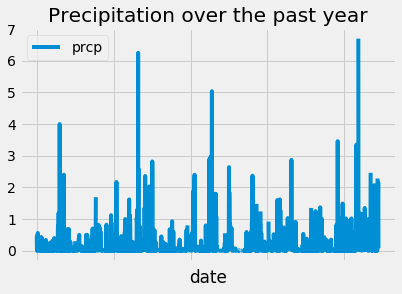

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
year = session.query(Measurement)
# Calculate the date 1 year ago from today
# last_year = dt.datetime.strftime(dt.datetime.today() - dt.timedelta(days=365), "%Y-%m-%d")
last_year = date(2017,8,23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement).filter(Measurement.date > last_year)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(query.statement,engine)
# Sort the dataframe by date
precip_df = precip_df.sort_values(by="date",ascending=False)
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="date",y="prcp",title="Precipitation over the past year")
# Rotate the xticks for the dates
# precip_df.plot(x="date",y="prcp",title="Precipitation over the past year",rot=0) # I tried
plt.show()

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


In [48]:
# How many stations are available in this dataset?
stations = session.query(func.count(sqlalchemy.distinct(Measurement.station)))
for row in stations:
    print(row)

(9,)


In [49]:
# What are the most active stations?
# List the stations and the counts in descending order.
by_station = session.query(Measurement.station,func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc())
for row in by_station:
    print(row)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(Measurement.id,Measurement.tobs).filter_by(tobs = func.min(Measurement.tobs),station='USC00519281')
highest_temp = session.query(Measurement.id,Measurement.tobs).filter_by(tobs = func.min(Measurement.tobs),station='USC00519281')
avg_temp = session.query(Measurement.id,Measurement.tobs).filter_by(tobs = func.min(Measurement.tobs),station='USC00519281')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D99A69C5C0>]],
      dtype=object)

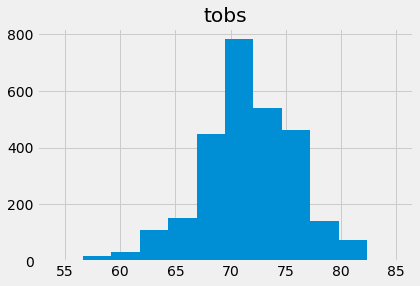

In [65]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_last_year = session.query(Measurement).filter_by(station='USC00519281')
most_active_df = pd.read_sql(most_active_last_year.statement, engine)
most_active_df.hist(column="tobs",bins=12)

In [52]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps= calc_temps("2017-08-05","2017-08-12")
trip_temps

[(71.0, 79.36666666666666, 83.0)]

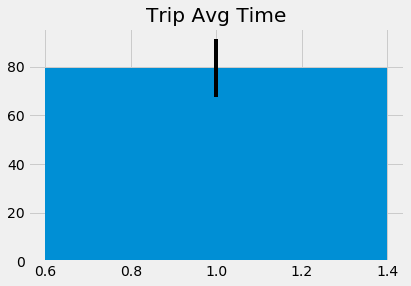

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
p2p=(trip_temps[0][2]-trip_temps[0][0])
plt.bar(x=1,height=trip_temps[0][1],yerr=p2p)
plt.title("Trip Avg Time")
plt.show()

In [55]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp).filter(Measurement.station==Station.station).filter(Measurement.date.between("2017-08-05", "2017-08-12")).order_by(Measurement.prcp.desc())
print(query)

SELECT station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, measurement.prcp AS measurement_prcp 
FROM station, measurement 
WHERE measurement.station = station.station AND measurement.date BETWEEN ? AND ? ORDER BY measurement.prcp DESC


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
